## ЗАДАЧА
У вас есть сеты с данными по ежедневным прдажам. Ваша задача - **спрогнозировать объем проданных товаров на ближайшие пару месяцев**. 
Для этого в первую очередь вам нужно произвести действи ядля очистки и подготовки данных (Feature Engeniring) - в этом блоке будут небольшие подсказки. Необходимо использовать три разных варианта моделей для прогноза. Не забудьте проверить модель на адекватность.

**Описание полей**:

- ID - идентификатор строки
- shop_id - уникальный идентификатор магазина
- item_id - уникальный идентификатор продукта
- item_category_id - уникальный идентификатор категории товара
- date_block_num - последовательный номер месяца (для удобства). Например, January 2013 - 0, February 2013 - 1,..., October 2015 - 33
- date - дата в формате dd/mm/yyyy
- item_cnt_day - количество вроданного товара.
- item_price - цена единцы товара
- item_name - Название товара
- shop_name - Название магазина
- item_category_name - Название категории товара

In [1]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

### 1. Загружаем данные

In [2]:
item_categories = pd.read_csv('item_categories.csv')
item_categories

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [3]:
items = pd.read_csv('items.csv')
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [4]:
sales_train = pd.read_csv('sales_train.csv')
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.00
1,03.01.2013,0,25,2552,899.00,1.00
2,05.01.2013,0,25,2552,899.00,-1.00
3,06.01.2013,0,25,2554,1709.05,1.00
4,15.01.2013,0,25,2555,1099.00,1.00
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.00
2935845,09.10.2015,33,25,7460,299.00,1.00
2935846,14.10.2015,33,25,7459,349.00,1.00
2935847,22.10.2015,33,25,7440,299.00,1.00


In [5]:
shops = pd.read_csv('shops.csv')
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


### 2. Объединяем датасеты

In [99]:
ob = pd.merge(sales_train, items, on='item_id', how='inner')
ob = pd.merge(ob, item_categories, on='item_category_id', how='inner')
ob = pd.merge(ob, shops, on='shop_id', how='inner')
ob

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.00,1.00,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,26.04.2013,3,59,944,150.00,1.00,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
2,26.06.2013,5,59,944,199.50,1.00,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
3,20.07.2013,6,59,944,199.50,1.00,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
4,14.09.2013,8,59,944,299.00,2.00,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
...,...,...,...,...,...,...,...,...,...,...
2935844,22.10.2015,33,55,13093,250.00,1.00,Карта оплаты Windows: 250 рублей [Цифровая вер...,36,Карты оплаты - Windows (Цифра),Цифровой склад 1С-Онлайн
2935845,21.09.2015,32,55,13091,1000.00,1.00,Карта оплаты Windows: 1000 рублей [Цифровая ве...,36,Карты оплаты - Windows (Цифра),Цифровой склад 1С-Онлайн
2935846,16.09.2015,32,55,13094,2500.00,1.00,Карта оплаты Windows: 2500 рублей [Цифровая ве...,36,Карты оплаты - Windows (Цифра),Цифровой склад 1С-Онлайн
2935847,22.09.2015,32,55,13094,2500.00,2.00,Карта оплаты Windows: 2500 рублей [Цифровая ве...,36,Карты оплаты - Windows (Цифра),Цифровой склад 1С-Онлайн


### 3. Выведем количество строк и столбцов в полученном сете

In [100]:
ob.shape

(2935849, 10)

### 4. Транспонируем фрейм и выведем первые 5 столбцов

In [101]:
obtr = ob.loc[0:4]
obtr = obtr.T
obtr

,0,1,2,3,4
date,02.01.2013,26.04.2013,26.06.2013,20.07.2013,14.09.2013
date_block_num,0,3,5,6,8
shop_id,59,59,59,59,59
item_id,22154,944,944,944,944
item_price,999.00,150.00,199.50,199.50,299.00
item_cnt_day,1.00,1.00,1.00,1.00,2.00
item_name,ЯВЛЕНИЕ 2012 (BD),2012 (BD),2012 (BD),2012 (BD),2012 (BD)
item_category_id,37,37,37,37,37
item_category_name,Кино - Blu-Ray,Кино - Blu-Ray,Кино - Blu-Ray,Кино - Blu-Ray,Кино - Blu-Ray
shop_name,"Ярославль ТЦ ""Альтаир""","Ярославль ТЦ ""Альтаир""","Ярославль ТЦ ""Альтаир""","Ярославль ТЦ ""Альтаир""","Ярославль ТЦ ""Альтаир"""


### 5. Используем соответствующую функцию, чтобы вывести полное описание столбцов в соответствии со статистическими показателями


In [102]:
ob.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.85,1.24,40.00
std,9.42,16.23,6324.30,1729.80,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


### 6. За какой период представлены данные в датасете?

In [103]:
ob['date'] = pd.to_datetime(ob['date'], format='%d.%m.%Y')

In [104]:
perv = ob['date'].min()
posl = ob['date'].max()
print(f'В датасете представлены данные с {perv} по {posl}')

В датасете представлены данные с 2013-01-01 00:00:00 по 2015-10-31 00:00:00


### 7. Начинаем очистку данных
Выведем только те строки, в которых цена не равна 0

In [105]:
ob = ob[(ob['item_price'] > 0)]
ob

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,2013-01-02,0,59,22154,999.00,1.00,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,2013-04-26,3,59,944,150.00,1.00,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
2,2013-06-26,5,59,944,199.50,1.00,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
3,2013-07-20,6,59,944,199.50,1.00,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
4,2013-09-14,8,59,944,299.00,2.00,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-22,33,55,13093,250.00,1.00,Карта оплаты Windows: 250 рублей [Цифровая вер...,36,Карты оплаты - Windows (Цифра),Цифровой склад 1С-Онлайн
2935845,2015-09-21,32,55,13091,1000.00,1.00,Карта оплаты Windows: 1000 рублей [Цифровая ве...,36,Карты оплаты - Windows (Цифра),Цифровой склад 1С-Онлайн
2935846,2015-09-16,32,55,13094,2500.00,1.00,Карта оплаты Windows: 2500 рублей [Цифровая ве...,36,Карты оплаты - Windows (Цифра),Цифровой склад 1С-Онлайн
2935847,2015-09-22,32,55,13094,2500.00,2.00,Карта оплаты Windows: 2500 рублей [Цифровая ве...,36,Карты оплаты - Windows (Цифра),Цифровой склад 1С-Онлайн


### 8. Чтобы избежать утечки данных, оставим только те столбцы, которые содержат только id 

In [106]:
ob.drop(columns=['item_name', 'item_category_name', 'shop_name'], inplace=True)
ob

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,2013-01-02,0,59,22154,999.00,1.00,37
1,2013-04-26,3,59,944,150.00,1.00,37
2,2013-06-26,5,59,944,199.50,1.00,37
3,2013-07-20,6,59,944,199.50,1.00,37
4,2013-09-14,8,59,944,299.00,2.00,37
...,...,...,...,...,...,...,...
2935844,2015-10-22,33,55,13093,250.00,1.00,36
2935845,2015-09-21,32,55,13091,1000.00,1.00,36
2935846,2015-09-16,32,55,13094,2500.00,1.00,36
2935847,2015-09-22,32,55,13094,2500.00,2.00,36


### 9. Сгруппируем данные по номерам месяцев

In [107]:
# ob['Year'] = pd.to_datetime(ob['date']).dt.year
# ob['Month'] = pd.to_datetime(ob['date']).dt.month
# ob['year_month'] = ob['Year'].map(str) + str('-') + ob['Month'].map(str)
# ob['year_month']= pd.to_datetime(ob['date'], format='%Y-%m')
# ob['year_month'] = ob['year_month'].astype('datetime64[ns]')
ob['Year_month'] = pd.DatetimeIndex(ob['date']).strftime('%Y-%m')
ob

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,Year_month
0,2013-01-02,0,59,22154,999.00,1.00,37,2013-01
1,2013-04-26,3,59,944,150.00,1.00,37,2013-04
2,2013-06-26,5,59,944,199.50,1.00,37,2013-06
3,2013-07-20,6,59,944,199.50,1.00,37,2013-07
4,2013-09-14,8,59,944,299.00,2.00,37,2013-09
...,...,...,...,...,...,...,...,...
2935844,2015-10-22,33,55,13093,250.00,1.00,36,2015-10
2935845,2015-09-21,32,55,13091,1000.00,1.00,36,2015-09
2935846,2015-09-16,32,55,13094,2500.00,1.00,36,2015-09
2935847,2015-09-22,32,55,13094,2500.00,2.00,36,2015-09


In [210]:
ob['revenue'] = ob['item_price'] * ob['item_cnt_day']
revvv = ob.groupby(['Year_month'], as_index=False).agg(revenue=('revenue', 'sum'))
revvv

,Year_month,revenue
0,2013-01,91946942.13
1,2013-02,90665707.37
2,2013-03,104932687.15
3,2013-04,69154285.55
4,2013-05,65065313.46
5,2013-06,79550405.83
6,2013-07,69350599.88
7,2013-08,74297969.64
8,2013-09,119081891.68
9,2013-10,107241612.53


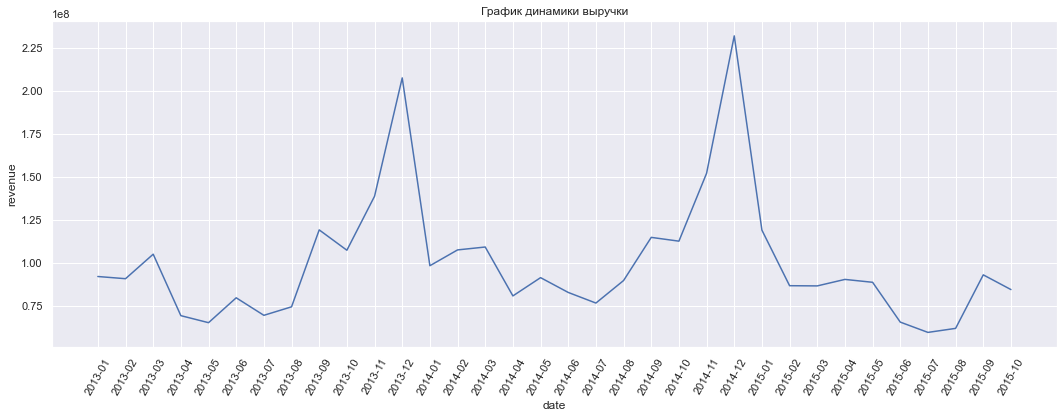

In [223]:
plt.figure(figsize=(18,6))
plt.plot(revvv['Year_month'], revvv['revenue'], color='b')

plt.title('График динамики выручки')
plt.xticks(np.arange(0,34,1))
plt.xticks(rotation=60)
plt.ylabel("revenue")
plt.xlabel("date")
plt.show()

In [109]:
ob.groupby(['Year_month', 'item_id'], as_index=False).agg(count=('item_id', 'count'))

,Year_month,item_id,count
0,2013-01,19,1
1,2013-01,27,7
2,2013-01,28,8
3,2013-01,29,6
4,2013-01,32,225
...,...,...,...
233907,2015-10,22162,10
233908,2015-10,22163,25
233909,2015-10,22164,15
233910,2015-10,22166,6


### 10. Добавим столбцы  с месяцем и годом для последующей возможной агрегации

In [110]:
# ob['Year'] = pd.to_datetime(ob['date']).dt.year
# ob['Month'] = pd.to_datetime(ob['date']).dt.month 

### 11. Исследуем данные

**11.1 EDA (Exploratory Data Analysis)**

In [111]:
ob.dtypes

date                datetime64[ns]
date_block_num               int64
shop_id                      int64
item_id                      int64
item_price                 float64
item_cnt_day               float64
item_category_id             int64
Year_month                  object
revenue                    float64
dtype: object

In [113]:
ob.count()

date                2935848
date_block_num      2935848
shop_id             2935848
item_id             2935848
item_price          2935848
item_cnt_day        2935848
item_category_id    2935848
Year_month          2935848
revenue             2935848
dtype: int64

In [112]:
ob[ob.duplicated()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,Year_month,revenue
247011,2014-07-12,18,25,3423,999.00,1.00,23,2014-07,999.00
894970,2013-01-05,0,54,20130,149.00,1.00,40,2013-01,149.00
966029,2014-12-31,23,42,21619,499.00,1.00,37,2014-12,499.00
1916247,2014-03-23,14,21,3423,999.00,1.00,23,2014-03,999.00
2328284,2014-02-23,13,50,3423,999.00,1.00,23,2014-02,999.00
2328295,2014-05-01,16,50,3423,999.00,1.00,23,2014-05,999.00


In [114]:
ob = ob.drop_duplicates()
ob

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,Year_month,revenue
0,2013-01-02,0,59,22154,999.00,1.00,37,2013-01,999.00
1,2013-04-26,3,59,944,150.00,1.00,37,2013-04,150.00
2,2013-06-26,5,59,944,199.50,1.00,37,2013-06,199.50
3,2013-07-20,6,59,944,199.50,1.00,37,2013-07,199.50
4,2013-09-14,8,59,944,299.00,2.00,37,2013-09,598.00
...,...,...,...,...,...,...,...,...,...
2935844,2015-10-22,33,55,13093,250.00,1.00,36,2015-10,250.00
2935845,2015-09-21,32,55,13091,1000.00,1.00,36,2015-09,1000.00
2935846,2015-09-16,32,55,13094,2500.00,1.00,36,2015-09,2500.00
2935847,2015-09-22,32,55,13094,2500.00,2.00,36,2015-09,5000.00


In [115]:
ob.isnull().sum() 
# ob = ob.dropna()
# ob.count()

date                0
date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_category_id    0
Year_month          0
revenue             0
dtype: int64

**11.2 Какова динамика продаж?** (изобразите графически)

In [116]:
sales = ob.groupby(['Year_month'], as_index=False).agg(sale_count=('item_cnt_day', 'sum'))
sales

,Year_month,sale_count
0,2013-01,131478.00
1,2013-02,128090.00
2,2013-03,147142.00
3,2013-04,107190.00
4,2013-05,106969.00
5,2013-06,125381.00
6,2013-07,116966.00
7,2013-08,125291.00
8,2013-09,133332.00
9,2013-10,127541.00


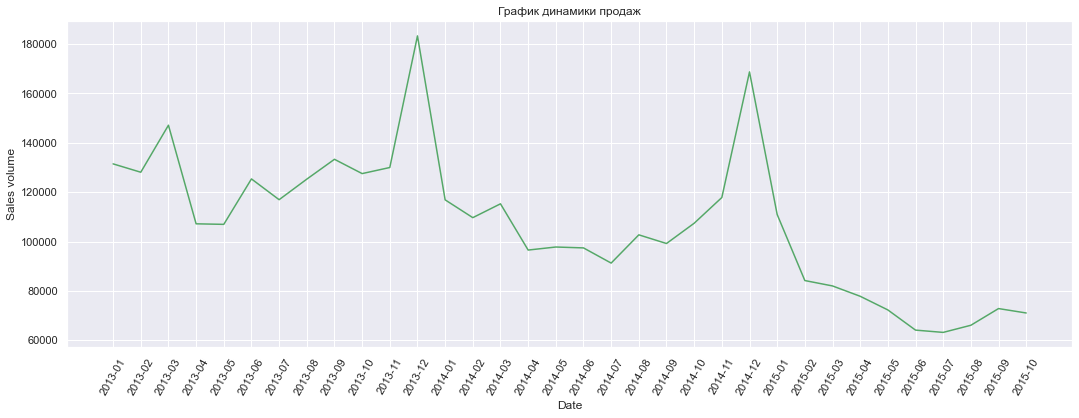

In [224]:
plt.figure(figsize=(18,6))
plt.plot(sales['Year_month'], sales['sale_count'], color='g')

plt.title('График динамики продаж')
plt.xticks(np.arange(0,34,1))
plt.xticks(rotation=60)
plt.ylabel('Sales volume')
plt.xlabel('Date')
plt.show()

**11.3 Какие категории имеют наибольшие продажи?**
(изобразите графически)

In [118]:
kat = ob.groupby(['item_category_id'], as_index=False).agg(sale_count=('item_cnt_day', 'sum'))
kat = kat.sort_values(by=['sale_count'], ascending=False)
kat[:10]

,item_category_id,sale_count
40,40,634170.00
30,30,456540.00
55,55,348591.00
19,19,254886.00
37,37,203283.00
71,71,187998.00
28,28,174954.00
23,23,169940.00
20,20,127319.00
65,65,73077.00


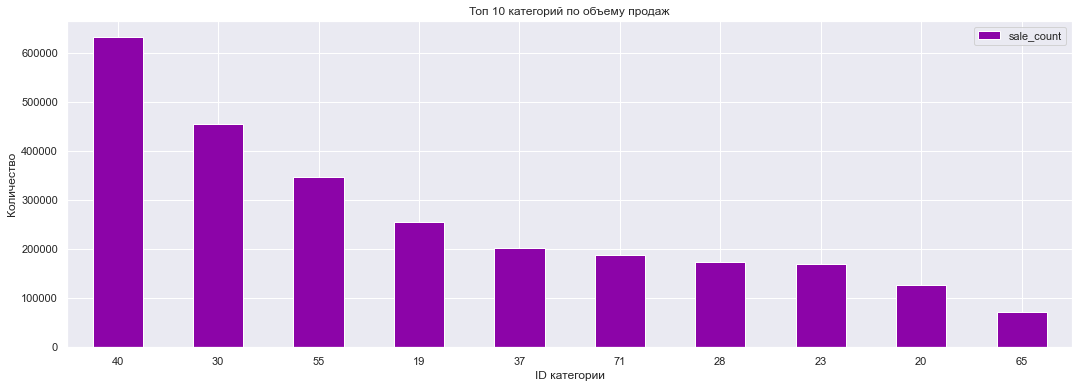

In [230]:
kat10 = kat[:10]
kat10[['item_category_id', 'sale_count']].plot(x='item_category_id', kind='bar', color=['#8C04A8'], figsize=(18,6))
plt.title('Топ 10 категорий по объему продаж')
plt.xlabel('ID категории')
plt.ylabel('Количество')
plt.xticks(rotation=360)
plt.show()

**11.4 Какие магазины имеют наибольшие продажи?** (изобразите графически)

In [225]:
mag = ob.groupby(['shop_id'], as_index=False).agg(sale_count=('item_cnt_day', 'sum'))
mag = mag.sort_values(by=['sale_count'], ascending=False)
mag[:10]

,shop_id,sale_count
31,31,310777.00
25,25,241919.00
54,54,185789.00
28,28,184557.00
42,42,144933.00
57,57,141107.00
27,27,136657.00
6,6,100489.00
58,58,81734.00
46,46,78990.00


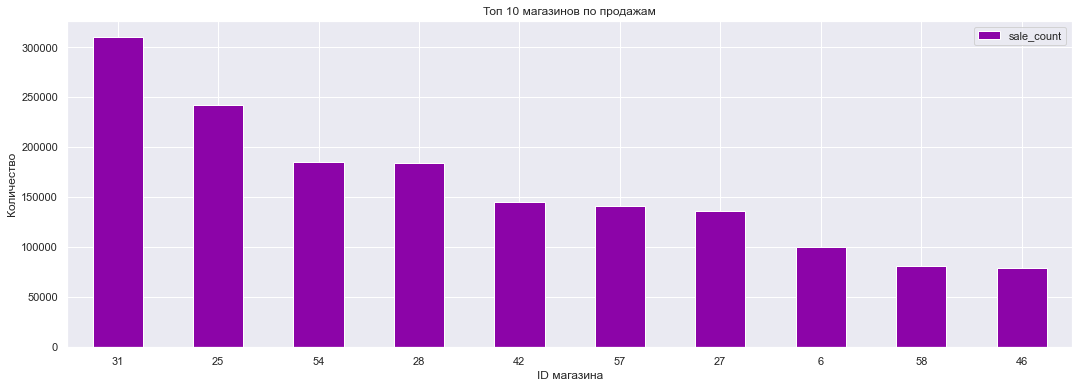

In [231]:
mag10 = mag[:10]
mag10[['shop_id', 'sale_count']].plot(x='shop_id', kind='bar', color=['#8C04A8'], figsize=(18,6))
plt.title('Топ 10 магазинов по продажам')
plt.xlabel('ID магазина')
plt.ylabel('Количество')
plt.xticks(rotation=360)
plt.show()

**11.5 Какие категории имеют наибольшую выручку?** (изобразите графически)

In [233]:
katr = ob.groupby(['item_category_id'], as_index=False).agg(revenue=('revenue', 'sum'))
katr = katr.sort_values(by=['revenue'], ascending=False)
katr[:10]

,item_category_id,revenue
19,19,412050281.90
20,20,373010312.01
12,12,292239761.98
23,23,259615132.35
30,30,257519291.08
40,40,169944072.69
28,28,136419148.64
55,55,100022563.57
37,37,90478232.84
75,75,87085926.18


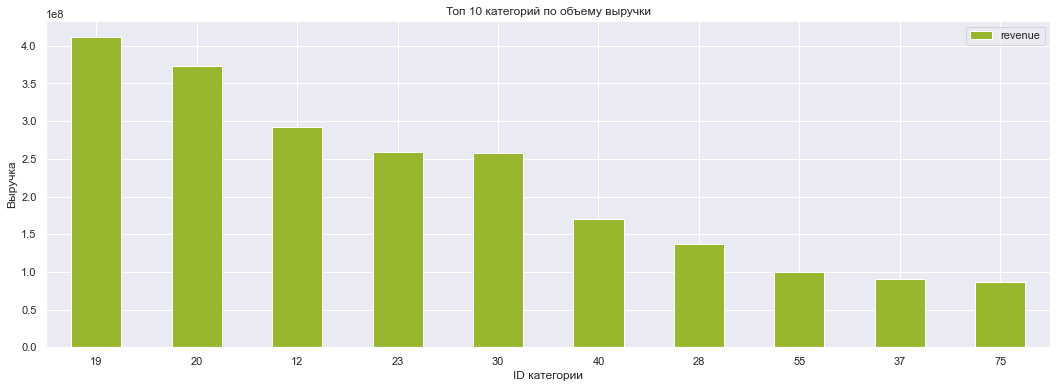

In [238]:
katr10 = katr[:10]
katr10[['item_category_id', 'revenue']].plot(x='item_category_id', kind='bar', color=['#98B72E'], figsize=(18,6))
plt.title('Топ 10 категорий по объему выручки')
plt.xlabel('ID категории')
plt.ylabel('Выручка')
plt.xticks(rotation=360)
plt.show()

**11.6 Какие магазины имеют наибольшую выручку?** (изобразите графически)

In [239]:
magr = ob.groupby(['shop_id'], as_index=False).agg(revenue=('revenue', 'sum'))
magr = magr.sort_values(by=['revenue'], ascending=False)
magr[:10]

,shop_id,revenue
31,31,235217019.05
25,25,216479572.44
28,28,159746337.38
42,42,151916533.55
54,54,141939524.00
27,27,140632474.12
57,57,112999783.53
12,12,112205072.86
6,6,98067453.80
18,18,83392700.99


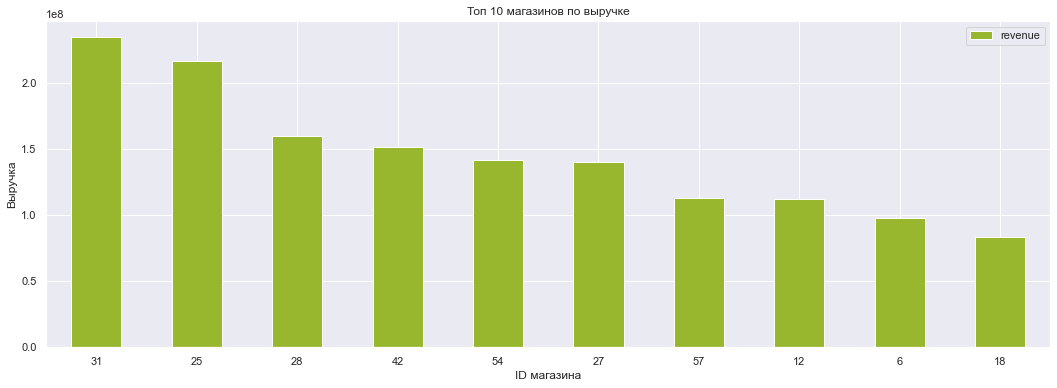

In [241]:
magr10 = magr[:10]
magr10[['shop_id', 'revenue']].plot(x='shop_id', kind='bar', color=['#98B72E'], figsize=(18,6))
plt.title('Топ 10 магазинов по выручке')
plt.xlabel('ID магазина')
plt.ylabel('Выручка')
plt.xticks(rotation=360)
plt.show()

### 12. Проверяем наличие выбросов (для этих целей можно использовать график) (по выручке)
Выбросы - значения не попадащие под распределение

In [120]:
Q1 = ob['revenue'].quantile(0.25)
Q3 = ob['revenue'].quantile(0.75)
IQR = (ob['revenue'].quantile(0.75) - ob['revenue'].quantile(0.25))

In [121]:
countvibr = len(ob[(ob['revenue'] > Q3+1.5*IQR) | (ob['revenue'] < Q1-1.5*IQR)])
countextr = len(ob[(ob['revenue'] > Q3+3*IQR) | (ob['revenue'] < Q1-3*IQR)])
print(f'Количество выбросов составляет {countvibr}, количество экстремальных выбросов {countextr}')

Количество выбросов составляет 297251, количество экстремальных выбросов 122337


### 13. Удаляем выбросы

In [122]:
# будем исключать только экстремальные выбросы
nov = ob[(ob['revenue'] < Q3+3*IQR) & (ob['revenue'] > Q1-3*IQR)]
nov

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,Year_month,revenue
0,2013-01-02,0,59,22154,999.00,1.00,37,2013-01,999.00
1,2013-04-26,3,59,944,150.00,1.00,37,2013-04,150.00
2,2013-06-26,5,59,944,199.50,1.00,37,2013-06,199.50
3,2013-07-20,6,59,944,199.50,1.00,37,2013-07,199.50
4,2013-09-14,8,59,944,299.00,2.00,37,2013-09,598.00
...,...,...,...,...,...,...,...,...,...
2935843,2015-10-20,33,55,13093,250.00,1.00,36,2015-10,250.00
2935844,2015-10-22,33,55,13093,250.00,1.00,36,2015-10,250.00
2935845,2015-09-21,32,55,13091,1000.00,1.00,36,2015-09,1000.00
2935846,2015-09-16,32,55,13094,2500.00,1.00,36,2015-09,2500.00


In [123]:
viz = nov.groupby(['Year_month'], as_index=False).agg(revenue=('revenue', 'sum'))

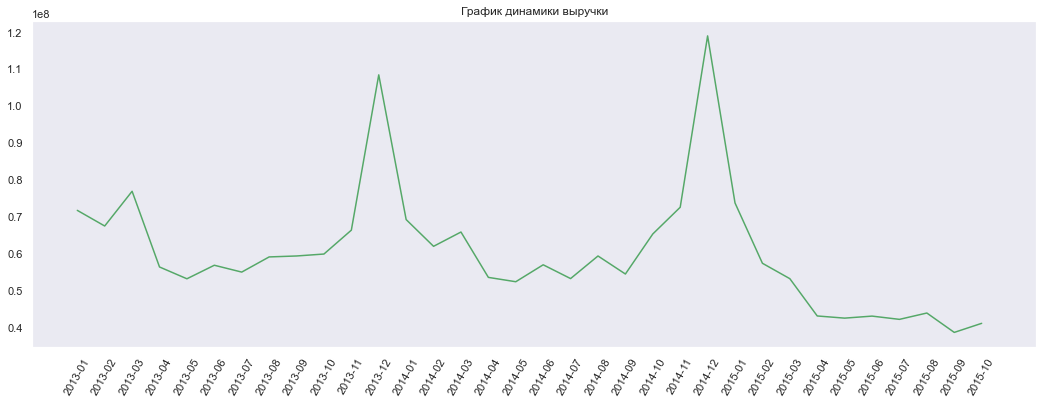

In [124]:
plt.figure(figsize=(18,6))
plt.plot(viz['Year_month'], viz['revenue'], color='g')

plt.title('График динамики выручки')
plt.grid()
plt.xticks(np.arange(0,36,1))
plt.xticks(rotation=60)
plt.show()

### 14. Насколько изменилась цена единицы товара в сравнениее с базисной (т.е. с самой первой в периоде) (последняя/первую и между всеми среднюю найти)

In [125]:
price = nov.groupby(['item_id'], as_index=False).agg(mindata = ('date', 'min'),
                                            maxdata = ('date', 'max'))
nov1 = nov.reindex(columns = ['item_id', 'date', 'item_price'])
nov1['mindata'] = nov1['date']
nov1['maxdata'] = nov1['date']
nov1 = nov1.reindex(columns = ['item_id', 'mindata', 'maxdata', 'item_price'])
nov1

,item_id,mindata,maxdata,item_price
0,22154,2013-01-02,2013-01-02,999.00
1,944,2013-04-26,2013-04-26,150.00
2,944,2013-06-26,2013-06-26,199.50
3,944,2013-07-20,2013-07-20,199.50
4,944,2013-09-14,2013-09-14,299.00
...,...,...,...,...
2935843,13093,2015-10-20,2015-10-20,250.00
2935844,13093,2015-10-22,2015-10-22,250.00
2935845,13091,2015-09-21,2015-09-21,1000.00
2935846,13094,2015-09-16,2015-09-16,2500.00


In [126]:
first_price = (pd.merge(price, nov1, on=['item_id', 'mindata'], how='left')).groupby(('item_id'), as_index=False).agg({'item_price': 'median'})
# first_price.drop(['maxdata_x', 'maxdata_y'], axis=1, inplace=True)
# first_price.drop_duplicates(subset='item_id', inplace=True)
first_price

,item_id,item_price
0,0,58.00
1,2,58.00
2,3,100.00
3,4,58.00
4,5,28.00
...,...,...
21301,22164,674.00
21302,22165,59.00
21303,22166,150.00
21304,22167,287.00


In [127]:
last_price = (pd.merge(price, nov1, on=['item_id', 'maxdata'], how='left')).groupby(('item_id'), as_index=False).agg({'item_price': 'median'})
last_price

,item_id,item_price
0,0,58.00
1,2,58.00
2,3,58.00
3,4,58.00
4,5,28.00
...,...,...
21301,22164,549.00
21302,22165,59.00
21303,22166,150.00
21304,22167,299.00


In [128]:
change = pd.DataFrame()
change['Growth rate'] = (last_price['item_price'] / first_price['item_price']) * 100 - 100
change.mean()

Growth rate   -14.13
dtype: float64

In [129]:
changenotnull = change[(change['Growth rate'] != 0)]
changenotnull.mean()

Growth rate   -26.60
dtype: float64

In [257]:
len(change)-len(changenotnull)

9989

### 15. Делаем прогноз (выручка)

детерминированная модель, метод главных компонент

In [130]:
prognoz = nov.groupby(['Year_month'], as_index=False).agg(revenue=('revenue', 'sum'))
prognoz

,Year_month,revenue
0,2013-01,71879083.87
1,2013-02,67648459.66
2,2013-03,77040880.32
3,2013-04,56571734.80
4,2013-05,53378721.91
5,2013-06,57038077.16
6,2013-07,55187549.58
7,2013-08,59286277.87
8,2013-09,59543870.45
9,2013-10,60068824.28


In [131]:
copy = prognoz.copy()
copy.index = pd.to_datetime(copy['Year_month'], format='%Y-%m')
copy.drop(columns=['Year_month'], inplace=True)
copy

,revenue
Year_month,
2013-01-01,71879083.87
2013-02-01,67648459.66
2013-03-01,77040880.32
2013-04-01,56571734.80
2013-05-01,53378721.91
2013-06-01,57038077.16
2013-07-01,55187549.58
2013-08-01,59286277.87
2013-09-01,59543870.45


In [132]:
# copy.index = pd.to_datetime(copy['date'], format="%Y-%m-%d")
# # copy.drop(columns=['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day', 'item_category_id', 'Year_month'], inplace=True)
# copy

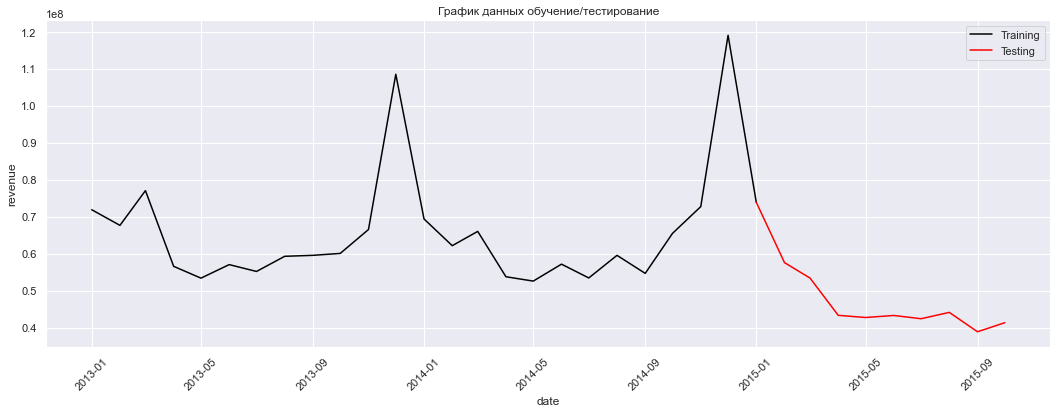

In [260]:
train = copy[copy.index <= pd.to_datetime('2015-01', format="%Y-%m")]
test = copy[copy.index >= pd.to_datetime('2015-01', format="%Y-%m")]
plt.figure(figsize=(18,6))
plt.plot(train, color = "black", label = "Training")
plt.plot(test, color = "red", label = "Testing")
plt.ylabel("revenue")
plt.xlabel("date")
plt.xticks(rotation=45)
plt.title('График данных обучение/тестирование')
plt.legend()
plt.show()

In [134]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [283]:
ARMAmodel = SARIMAX(copy, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()

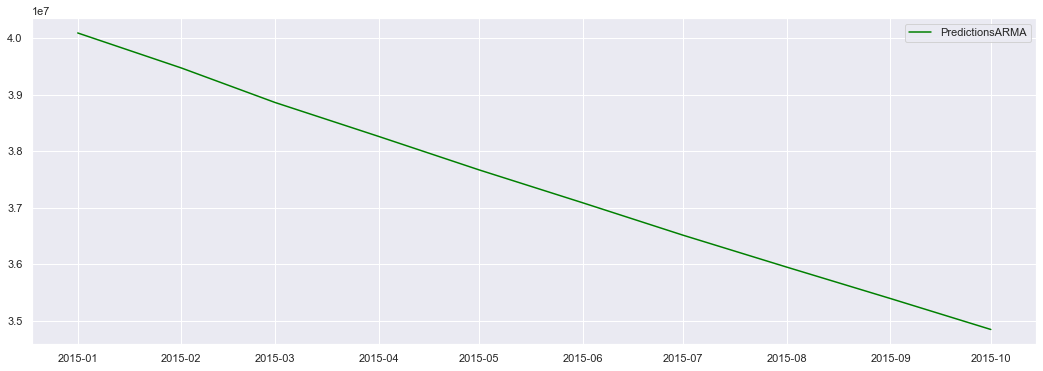

In [284]:
pred = ARMAmodel.get_forecast(len(test.index))
pred_df = pred.conf_int(alpha = 0.05)
pred_df["PredictionsARMA"] = ARMAmodel.predict(start = pred_df.index[0], end = pred_df.index[-1])
pred_df.index = test.index
predARMA = pred_df["PredictionsARMA"]
plt.figure(figsize=(18,6))
plt.plot(predARMA, color="green", label = "PredictionsARMA")
plt.legend()

In [285]:
arma_rmse = np.sqrt(mean_squared_error(test["revenue"].values, pred_df["PredictionsARMA"]))
print("RMSE: ",arma_rmse)

RMSE:  13879694.795692384


RMSE:  51689218.67022895


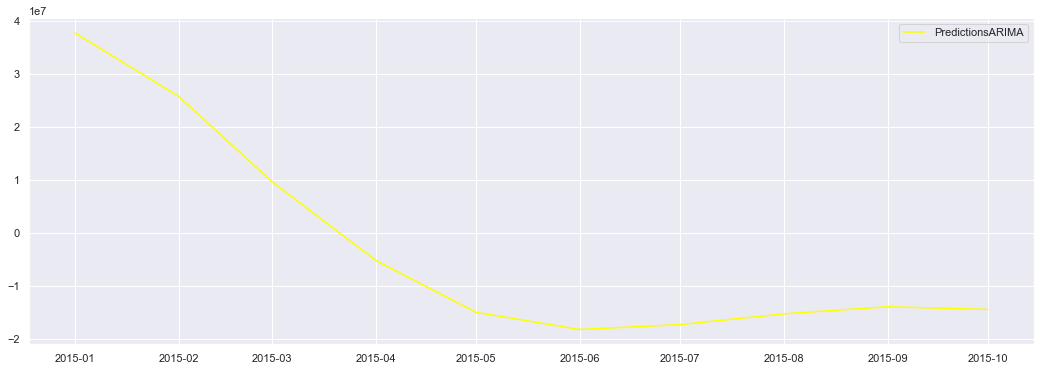

In [279]:
from statsmodels.tsa.arima.model import ARIMA

ARIMAmodel = ARIMA(copy, order=(9, 2, 2))
ARIMAmodel = ARIMAmodel.fit()
pred = ARIMAmodel.get_forecast(len(test.index))
pred_df = pred.conf_int(alpha = 0.05)
pred_df['PredictionsARIMA'] = ARIMAmodel.predict(start = pred_df.index[0], end = pred_df.index[-1])
pred_df.index = test.index
predARIMA = pred_df["PredictionsARIMA"]
plt.figure(figsize=(18,6))
plt.plot(predARIMA, color="Yellow", label = "PredictionsARIMA")
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test["revenue"].values, pred_df["PredictionsARIMA"]))
print("RMSE: ",arima_rmse)

SARIMA RMSE:  22820531.833101563


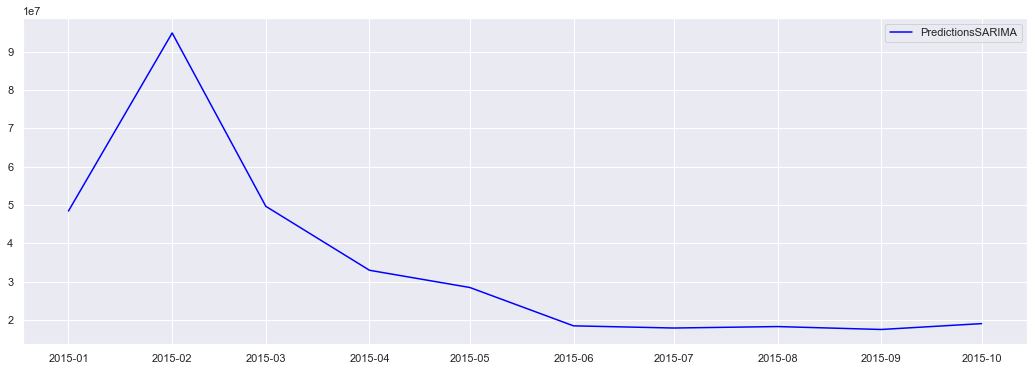

In [280]:
SARIMAXmodel = SARIMAX(copy, order = (0, 1, 1), seasonal_order=(0,1,1,12))
SARIMAXmodel = SARIMAXmodel.fit()
pred = SARIMAXmodel.get_forecast(len(test.index))
pred_df = pred.conf_int(alpha = 0.05)
pred_df["PredictionsSARIMA"] = SARIMAXmodel.predict(start = pred_df.index[0], end = pred_df.index[-1])
pred_df.index = test.index
pred_SARIMA = pred_df["PredictionsSARIMA"]
plt.figure(figsize=(18,6))
plt.plot(pred_SARIMA, color="Blue", label = "PredictionsSARIMA")
plt.legend()

sarima_rmse = np.sqrt(mean_squared_error(test["revenue"].values, pred_df["PredictionsSARIMA"]))
print("SARIMA RMSE: ",sarima_rmse)

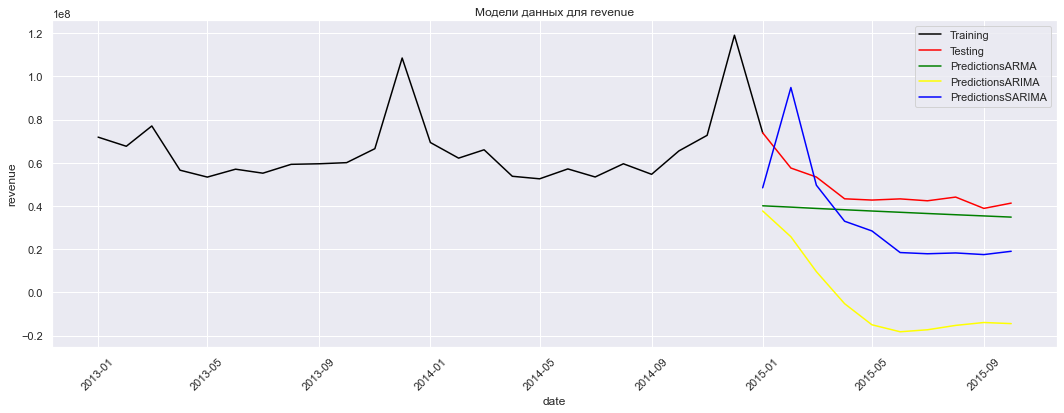

In [286]:
plt.figure(figsize=(18,6))
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.ylabel("revenue")
plt.xlabel("date")
plt.xticks(rotation=45)

plt.plot(predARMA, color="green", label = "PredictionsARMA")
plt.plot(predARIMA, color="Yellow", label = "PredictionsARIMA")
plt.plot(pred_SARIMA, color="Blue", label = "PredictionsSARIMA")

plt.title("Модели данных для revenue")
plt.legend()
plt.show()

In [282]:
print(f'RMSE ARMA: {arma_rmse.round(2)}')
print(f'RMSE ARIMA: {arima_rmse.round(2)}')
print(f'RMSE SARIMA: {sarima_rmse.round(2)}')

RMSE ARMA: 13879694.8
RMSE ARIMA: 51689218.67
RMSE SARIMA: 22820531.83


<div class="alert alert-block alert-warning">
<b> Построение прогноза с помощью ARIMA </b>
</div>

In [47]:
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score

In [48]:
row =  ['JB', 'p-value', 'skew', 'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(copy)
a = np.vstack([jb_test])
itog = SimpleTable(a.round(5), row)
itog

JB
39.31035
0.0
1.76262
6.91422


In [49]:
test = sm.tsa.adfuller(copy)
print('adf: ', test[0]) 
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0] > test[4]['5%']: 
    print ('Есть единичные корни, ряд не стационарен')
else:
    print( 'Единичных корней нет, ряд стационарен')

adf:  -3.0864062926346225
p-value:  0.027575676780668985
Critical values:  {'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}
Единичных корней нет, ряд стационарен


In [294]:
# copy1diff = copy.diff(periods=1).dropna()

# test = sm.tsa.adfuller(copy1diff)
# print('adf: ', test[0]) 
# print('p-value: ', test[1])
# print('Critical values: ', test[4])
# if test[0] > test[4]['5%']: 
#     print ('Есть единичные корни, ряд не стационарен')
# else:
#     print( 'Единичных корней нет, ряд стационарен')

In [295]:
# copy1diff.plot(figsize=(12,6))

In [143]:
import itertools

In [144]:
import warnings
warnings.filterwarnings("ignore")

p = range(0,10)
d = q = range(0,3)
pdq = list(itertools.product(p, d, q))
best_pdq = (0,0,0)
best_aic = np.inf
for params in pdq:
    model_test = ARIMA(copy, order = params)
    result_test = model_test.fit()
if result_test.aic < best_aic:
    best_pdq = params
    best_aic = result_test.aic
print(best_pdq, best_aic)

(9, 2, 2) 1180.3017504835893


In [175]:
model = ARIMA(copy, order=(9, 2, 2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                   34
Model:                 ARIMA(9, 2, 2)   Log Likelihood                -578.151
Date:                Fri, 22 Dec 2023   AIC                           1180.302
Time:                        19:12:43   BIC                           1197.891
Sample:                    01-01-2013   HQIC                          1186.132
                         - 10-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4058      0.262      1.550      0.121      -0.107       0.919
ar.L2         -0.3055      0.345     -0.886      0.375      -0.981       0.370
ar.L3         -0.3109      0.265     -1.174      0.2

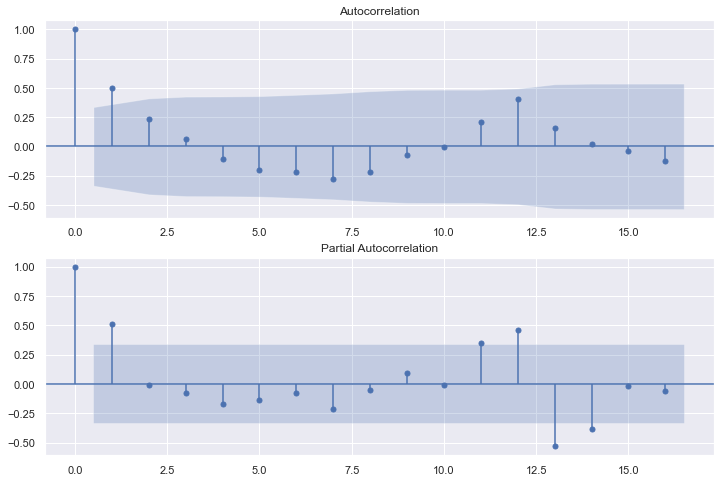

In [296]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(copy.values.squeeze(), ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(copy, ax=ax2)

In [297]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

forecast = model_fit.forecast(steps=6)

mse = mean_squared_error(copy[-6:], forecast)
mae = mean_absolute_error(copy[-6:], forecast)

print(f'MSE: {mse}')
print(f'MAE: {mae}')

MSE: 1716083421526474.0
MAE: 36362895.40841477


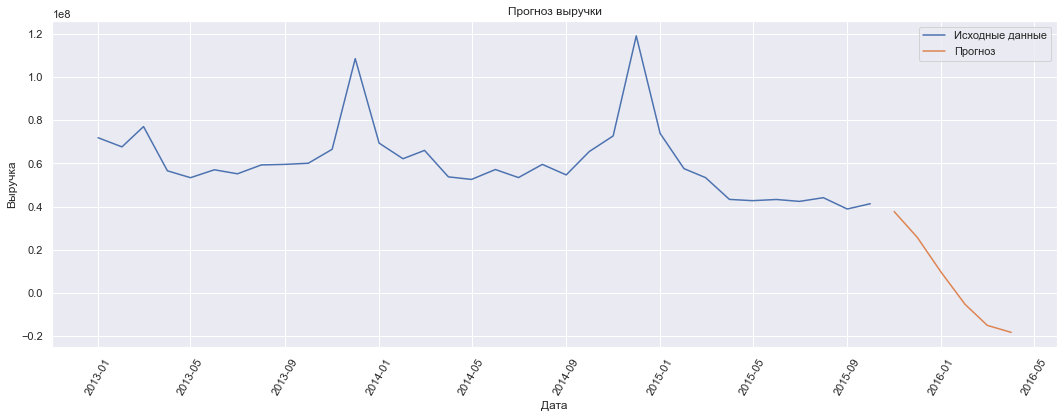

In [298]:
forecast_future = model_fit.forecast(steps=6)

future_dates = pd.date_range(start='2015-10', periods=6, freq='M')
forecast_df = pd.DataFrame({'Дата': future_dates, 'Прогноз выручки': forecast_future})
# copy = copy.append(forecast_df['Прогноз выручки'], ignore_index=True)

plt.figure(figsize=(18, 6))
plt.plot(copy.index, copy, label='Исходные данные')
plt.plot(forecast_df.index, forecast_df['Прогноз выручки'], label='Прогноз')
plt.title('Прогноз выручки')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend()
plt.grid(True)
plt.xticks(rotation=60)
plt.show()

<Figure size 1296x432 with 0 Axes>

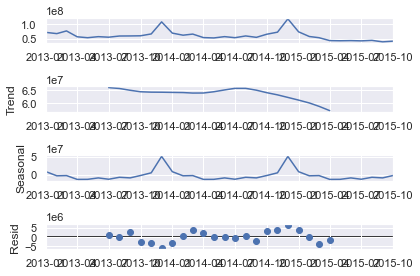

In [293]:
#добавим нужную библиотеку
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
#произведем декомпозицию временного ряда 

decomposition = seasonal_decompose(copy, freq=12)
fig = decomposition.plot()
plt.show()

<div class="alert alert-block alert-warning">
<b> Построение прогноза с помощью SARIMAX </b>
</div>

In [309]:
# Определите p, d и q в диапазоне 0-2
p = d = q = range(0, 2)
# Сгенерируйте различные комбинации p, q и q
pdq = list(itertools.product(p, d, q))
# Сгенерируйте комбинации сезонных параметров p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] 
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [310]:
warnings.filterwarnings("ignore") # отключает предупреждения
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(copy, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1280.4184122767992
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:799.0076565328001
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:741.9606821873101
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:313.3414220373973
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:769.4979731138027
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:745.6062512642975
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:359.98928265921614
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:312.99157615564553
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1222.6097334598703
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:761.8165263296875
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:700.2614846986206
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:281.4978223579473
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:835.76002567422
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:762.1403425415729
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:354.97631190237706
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:281.67440867598054
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1157.4489854777541
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:708.1070218933957
ARIMA

In [ ]:
# ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:236.03262902167359

In [312]:
mod = sm.tsa.statespace.SARIMAX(copy, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12), enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0190      0.219      0.086      0.931      -0.411       0.449
ma.S.L12       0.0421      0.099      0.424      0.671      -0.152       0.236
sigma2      2.707e+13   1.93e-16    1.4e+29      0.000    2.71e+13    2.71e+13


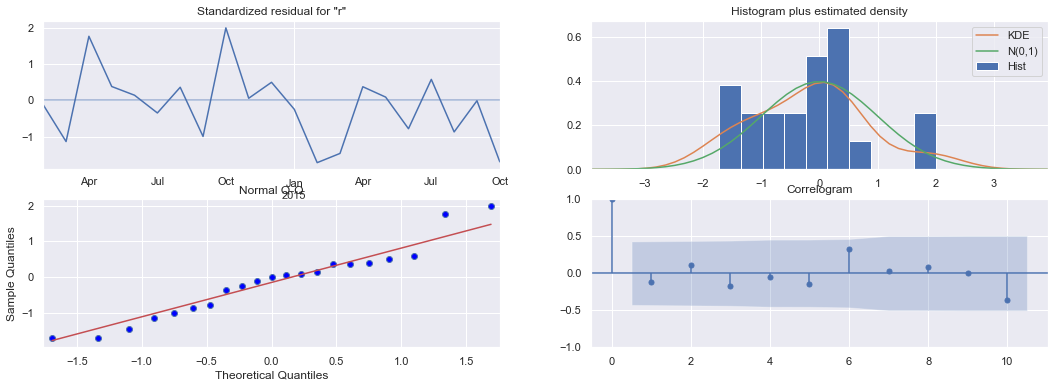

In [313]:
results.plot_diagnostics(figsize=(18, 6))
plt.show()

In [188]:
pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_ci = pred.conf_int()

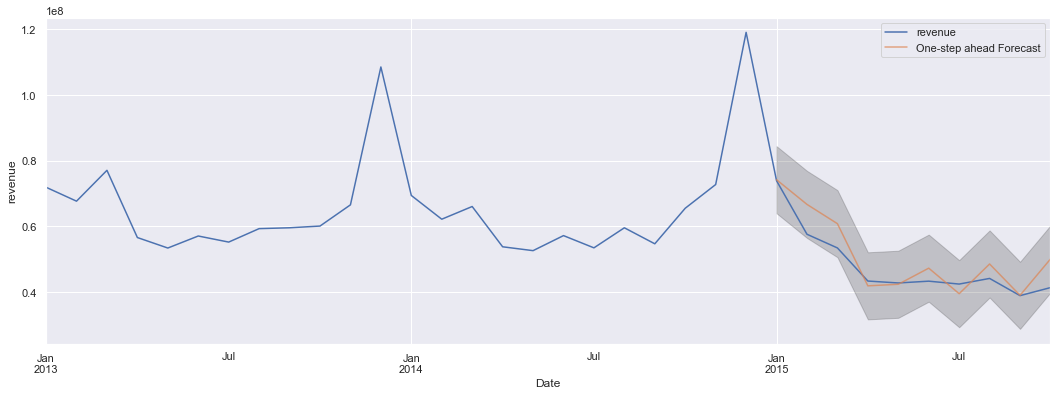

In [189]:
ax = copy['2013':].plot(label='observed', figsize=(18,6))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [156]:
copy_forecasted = pred.predicted_mean
copy_truth = copy['2015-01-01':] # Compute the mean square error
mse = ((copy_forecasted.to_numpy() - copy_truth.to_numpy()) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 245663767392247.3


In [157]:
def mape(copy_truth, copy_forecasted): 
    return np.mean(np.abs((copy_truth - copy_forecasted) / copy_truth)) * 100

In [158]:
mape(copy_truth.to_numpy(), copy_forecasted.to_numpy())

24.31599980596903

In [159]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

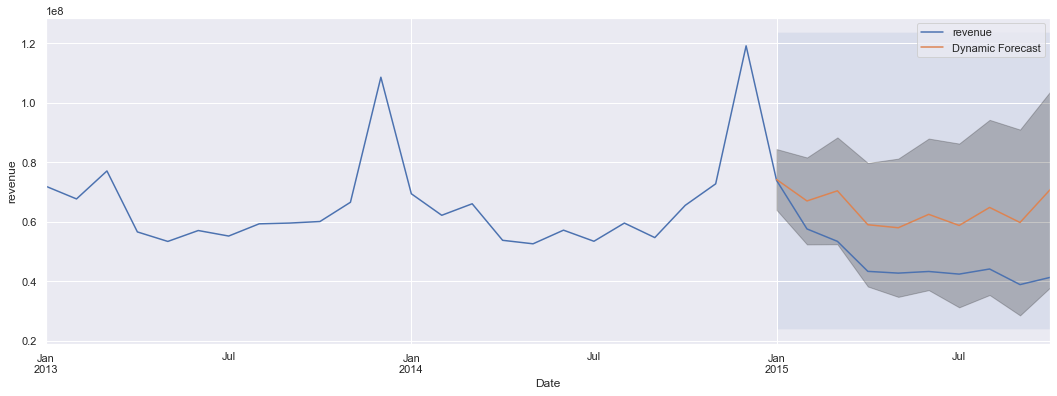

In [161]:
ax = copy['2013':].plot(label='observed', figsize=(18, 6))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)
ax.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-01-01'), copy.index[-1], alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [162]:
# Извлечь прогнозируемые и истинные значения временного ряда
copy_forecasted = pred_dynamic.predicted_mean
copy_truth = copy['2015-01-01':] # Вычислить среднеквадратичную ошибку
mse = ((copy_forecasted.to_numpy() - copy_truth.to_numpy()) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 403958429380869.5


In [163]:
mape(copy_truth.to_numpy(), copy_forecasted.to_numpy())

41.48329773349235

In [314]:
# Получить прогноз на 3 шага вперёд
pred_uc = results.get_forecast(steps=3)
# Получить интервал прогноза
pred_ci = pred_uc.conf_int()

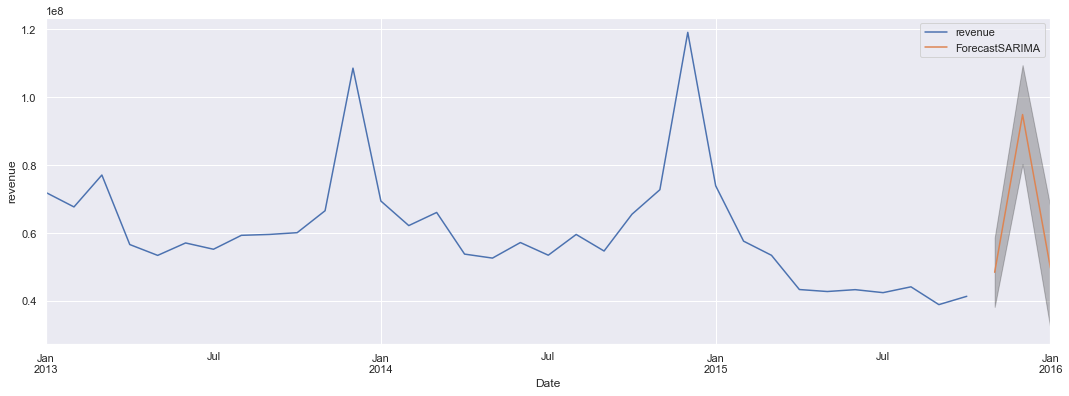

In [315]:
ax = copy.plot(label='observed', figsize=(18, 6))
pred_uc.predicted_mean.plot(ax=ax, label='ForecastSARIMA')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [300]:
mod = ARIMA(copy, order=(9, 2, 2))
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4058      0.262      1.550      0.121      -0.107       0.919
ar.L2         -0.3055      0.345     -0.886      0.375      -0.981       0.370
ar.L3         -0.3109      0.265     -1.174      0.240      -0.830       0.208
ar.L4         -0.2639      0.271     -0.973      0.331      -0.795       0.268
ar.L5         -0.2408      0.349     -0.690      0.490      -0.924       0.443
ar.L6         -0.2045      0.337     -0.608      0.543      -0.864       0.455
ar.L7         -0.2747      0.548     -0.501      0.616      -1.349       0.800
ar.L8         -0.2021      0.572     -0.353      0.724      -1.324       0.920
ar.L9         -0.0732      0.362     -0.202      0.840      -0.782       0.636
ma.L1         -1.6433      0.316     -5.193      0.000      -2.263      -1.023
ma.L2          0.9476      0.382      2.482      0.0

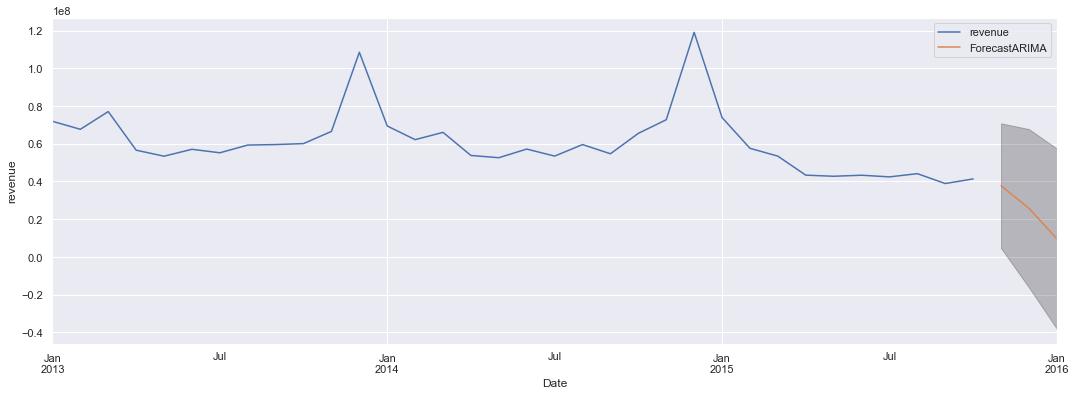

In [301]:
# Получить прогноз на 3 шага вперёд
pred_uc = results.get_forecast(steps=3)
# Получить интервал прогноза
pred_ci = pred_uc.conf_int()

ax = copy.plot(label='observed', figsize=(18, 6))
pred_uc.predicted_mean.plot(ax=ax, label='ForecastARIMA')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [318]:
mod = ARIMA(copy, order=(1, 0, 1))
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.058e+07   1.86e-09   3.26e+16      0.000    6.06e+07    6.06e+07
ar.L1          0.5137      0.553      0.930      0.353      -0.569       1.597
ma.L1         -0.0105      0.632     -0.017      0.987      -1.250       1.229
sigma2      2.186e+14   1.02e-15   2.15e+29      0.000    2.19e+14    2.19e+14


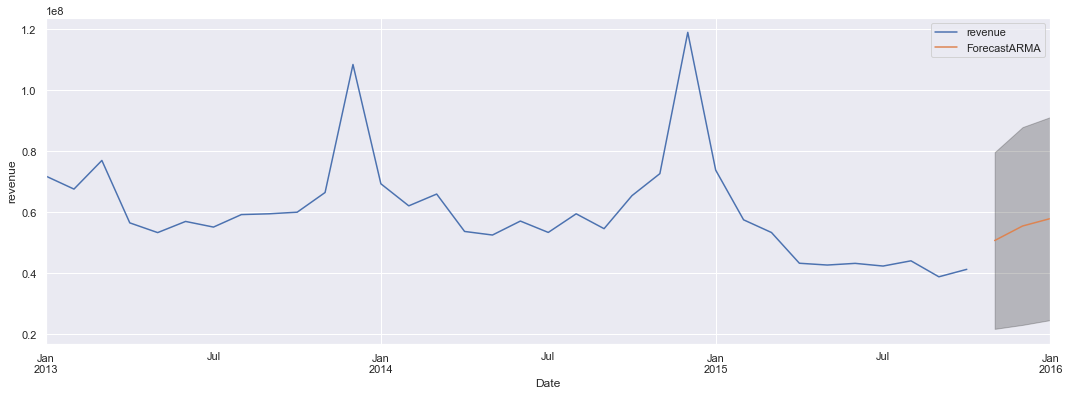

In [319]:
# Получить прогноз на 3 шага вперёд
pred_uc = results.get_forecast(steps=3)
# Получить интервал прогноза
pred_ci = pred_uc.conf_int()

ax = copy.plot(label='observed', figsize=(18, 6))
pred_uc.predicted_mean.plot(ax=ax, label='ForecastARMA')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('revenue')
plt.legend()
plt.show()